In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [2]:
u_min = .97
u_max = 1.04

tx_spread = 10

In [3]:
#vesting (should this be exposed in the app?)
cliff = 8 #weeks before vesting starts ~ 2 months
halflife = 52 #26 weeks, half life is ~6 months
#percentage of the hatch tokens which vest per week (since that is our timescale in the sim)

In [4]:
(u_min+u_max)/2

1.005

In [5]:
##########################################
# This block is a literal translation of #
# src/math.ts                            #
##########################################

#fair warning i pulled in analytically correct equations
#these equations have roots in them so always need to double check
#the packages we use to make sure edges near 0 are well handled.

# Computes the price at a specific reserve `R`
def getPriceR(R, V0, k):
    return (k * R ** ((k - 1) / k)) / V0 ** (1 / k)

# Compute the reserve `R` for a given supply `S`
def getR(S, V0, k):
    return (S)**k / V0

def getS(R, V0, k):
    return (V0*R)**(1/k)

# compute the reserve if all that supply is burned
def getMinR(S,H,V0,k):
    return getR(S-H, V0, k)

# compute the price if all that supply is burned
def getMinPrice(S, H, V0, k):
    if S == H:
        myR = getR(S,V0,k)
        myP = getPriceR(myR, V0, k) #numerical precision make complex numbers just suppress it
        return abs(myP)
    else:
        minR = getMinR(S,H,V0,k)
        return getPriceR(minR, V0, k)

# Compute slippage at a point `R`, given a `deltaR`
def getSlippage(R, deltaR, V0, k):
    S = (V0 * R) ** (1 / k)
    deltaS = (V0 * (R + deltaR)) ** (1 / k) - S
    realizedPrice = deltaR / deltaS
    spotPrice = getPriceR(R, V0, k)
    return abs(realizedPrice - spotPrice) / spotPrice

# Get deltaR for a given price growth factor
def getDeltaR_priceGrowth(R, k, priceGrowth):
    return -R + (priceGrowth * R ** (1 - 1 / k)) ** (k / (-1 + k))

# Computes a tx distribution using a normal distribution,
# Given a sum of tx value and a number of transactions
# Demo: https://codepen.io/anon/pen/mNqJjv?editors=0010#0
def getTxDistribution(_sum, num, spread):
    #spread is not exactly the variance
    #we could refactor it so it was but i don't think its the best use of time
    mean = _sum / num
    off = mean * spread 
    x = []
    for i in range(0, int(num)):
        x.append(randn_bm(mean - off, mean + off))
    return x

# Random variable uniformly distributed
def rv_U(min, max):
    return random.random() * (max - min) + min


# Standard Normal variate using Box-Muller transform.
# by https://stackoverflow.com/questions/25582882/javascript-math-random-normal-distribution-gaussian-bell-curve/36481059#36481059
def randn_bm(min, max):
    u = 0
    v = 0
    while (u == 0):
        u = random.random() # Converting [0,1) to (0,1)
    while (v == 0):
        v = random.random()
    num = math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * math.pi * v)
    
    num = num / 10.0 + 0.5; # Translate to 0 -> 1
    if (num > 1) or (num < 0):
        num = randn_bm(min, max) # resample between 0 and 1 if out of range
    num *= max - min # Stretch to fill range
    num += min # offset to min
    return num

def vest_tokens(week,unvested_hatch_tokens, halflife, cliff):
    #check cliff
    if week < cliff:
        return 0
    else:
        #rate of release given half-life 
        vest_fraction = .5**(1/halflife)
        #number of tokens that vest in this week
        return unvested_hatch_tokens*(1-vest_fraction)

In [6]:
##########################################
# This block represent the user choices  #
# src/App.ts                             #
##########################################

# Given data
d0 = 1e6
theta = 0.35
p0 = 0.1
p1 = 0.3
wFee = 0.05

# Initial params
k = p1 / p0 / (1 - theta)
R0 = (1 - theta) * d0
S0 = d0 / p0
V0 = S0 ** k / R0

In [7]:
##########################################
# Literal translation of the price walk  #
# in src/App.ts                          #
##########################################

# Price walk
R_t = [R0]
p_t = [getPriceR(R0, V0, k)]
S_t = [S0]
wFee_t = [0]
slippage_t = []
avgTxSize_t = []

#hatchers tokens = S0 [section added by Z]
H_t = [S0] #total hatcher tokens not vested
floorprice_t= [] #initially the price is the floor as all tokens are hatcher tokens

numSteps = 52

# adding some extra stored variables so i can see
dR_t = []
all_tx = []
mean_slippage_t = []

for t in range(0, numSteps):
    txsWeek = rv_U(5, 2 * t + 5)
    
    R= R_t[-1]
    S = S_t[-1]
    H = H_t[-1]
    #enforce the effects of the unvested tokens not being burnable
    #print((R,S,H))
    #print(getMinR(S,H,V0,k))
    if H == S:
        u_lower = 1
    else:
        R_ratio = np.real(getMinR(S,H,V0,k))/R
        u_lower = max([1-R_ratio,u_min])
    #print(u_lower)
    
    priceGrowth = rv_U(u_lower , u_max) #its misleading to call this price growth (its "reserve growth")

    deltaR = getDeltaR_priceGrowth(R, k, priceGrowth)
    
    #extra
    dR_t.append(deltaR) #may be commented out if not used for statistics

    R_next = R + deltaR
    txs = getTxDistribution(deltaR, txsWeek, tx_spread)
    # Compute slippage
    slippage_txs = [getSlippage(R, txR, V0, k) for txR in txs]
    slippage_mean = np.mean(slippage_txs)
    slippage_median = np.median(slippage_txs)
    
    txsWithdraw = filter(lambda tx: tx < 0, txs)
    wFees = -wFee * sum(txsWithdraw)

    #vest
    delta_H = vest_tokens(t,H, halflife, cliff)
    H_next = H-delta_H
    
    #find floor price
    S_next = getS(R, V0,k)
    #print(S)
    floorprice_next = getMinPrice(S_next, S0-H_next, V0, k)
    
    # Store variables
    R_t.append(R_next)
    p_t.append(getPriceR(R_next, V0, k))
    S_t.append(S_next)
    slippage_t.append(slippage_median)
    wFee_t.append(wFees)
    H_t.append(H_next)
    floorprice_t.append(floorprice_next)
    
    #use for statistics
    all_tx = all_tx + slippage_txs 
    mean_slippage_t.append(slippage_mean)

In [8]:
change_rate = np.array(dR_t)/np.array(R_t[:-1])

Text(0.5,1,'Slippage Histogram')

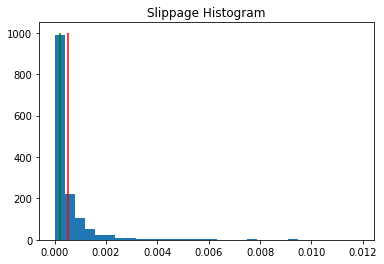

In [9]:
plt.hist(all_tx, 30)
plt.vlines(np.median(all_tx), 0, 1000, 'g')
plt.vlines(np.mean(all_tx), 0, 1000, 'r')
plt.title('Slippage Histogram')

Text(0.5,1,'Log Scaled slippage histogram')

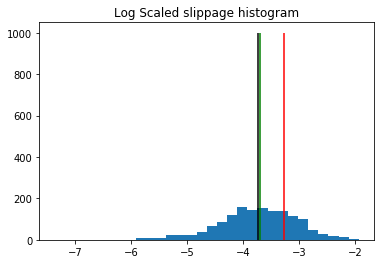

In [10]:
plt.hist(np.log10(all_tx), 30)
plt.vlines(np.log10(np.median(all_tx)), 0, 1000, 'g') #median of the logs = median of the log of the distribution
plt.vlines(np.mean(np.log10(all_tx)), 0, 1000, 'k') #mean of the log distribution
plt.vlines(np.log10(np.mean(all_tx)), 0, 1000, 'r') #log of the mean
plt.title('Log Scaled slippage histogram')

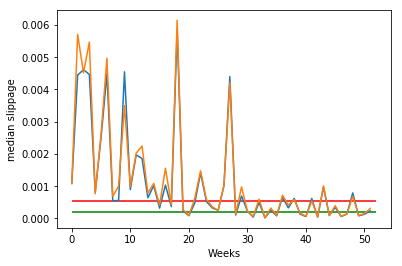

In [11]:
plt.plot(slippage_t)
plt.plot(mean_slippage_t)
plt.xlabel('Weeks')
plt.ylabel('median slippage')

plt.hlines(np.median(all_tx), 0, 52, 'g')
plt.hlines(np.mean(all_tx), 0, 52, 'r')

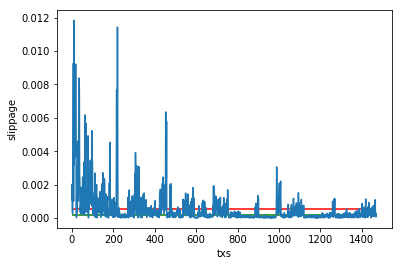

In [12]:
plt.plot(all_tx)
plt.xlabel('txs')
plt.ylabel('slippage')
K = len(all_tx)

plt.hlines(np.median(all_tx), 0,K , 'g')
plt.hlines(np.mean(all_tx), 0, K, 'r')

Text(0,0.5,'change_R')

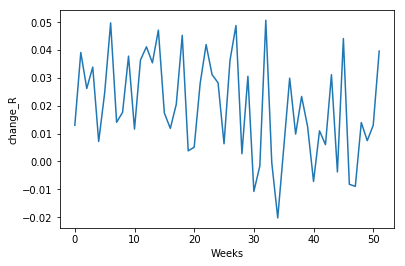

In [13]:
plt.plot(change_rate)
plt.xlabel('Weeks')
plt.ylabel('change_R')

(array([1., 4., 3., 8., 9., 3., 5., 8., 5., 6.]),
 array([-0.02025633, -0.01315972, -0.00606312,  0.00103349,  0.00813009,
         0.0152267 ,  0.02232331,  0.02941991,  0.03651652,  0.04361312,
         0.05070973]),
 <a list of 10 Patch objects>)

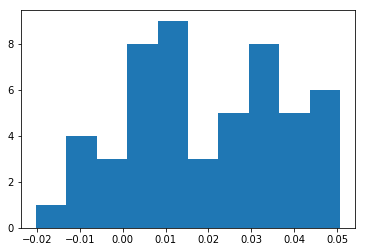

In [14]:
plt.hist(change_rate)

Text(0,0.5,'change_R')

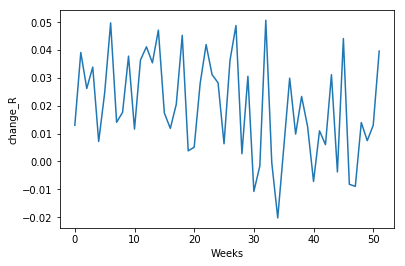

In [15]:
plt.plot(change_rate)
plt.xlabel('Weeks')
plt.ylabel('change_R')

Text(0,0.5,'Price')

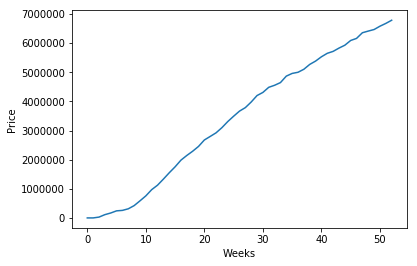

In [16]:
plt.plot(np.array(S_t)-np.array(H_t))
plt.xlabel('Weeks')
plt.ylabel('Price')

Text(0,0.5,'floorprice')

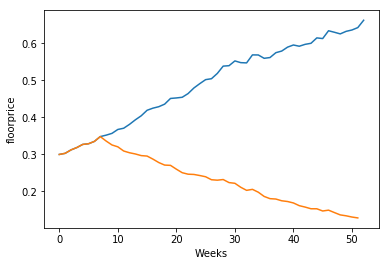

In [17]:
##########################################
# Same graph as the one showed after     #
# clicking "Run simulation"              #
##########################################

plt.plot(p_t)
plt.xlabel('Weeks')
plt.ylabel('Price')

plt.plot(floorprice_t)
plt.xlabel('Weeks')
plt.ylabel('floorprice')

Text(0,0.5,'price gap')

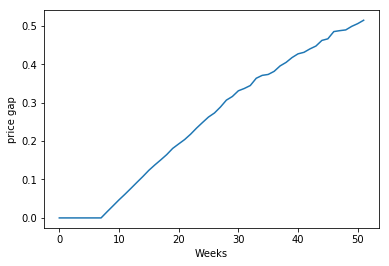

In [18]:
plt.plot(np.array(p_t[:-1])-np.array(floorprice_t))
plt.xlabel('Weeks')
plt.ylabel('price gap')

Text(0,0.5,'price gap as a percent of price')

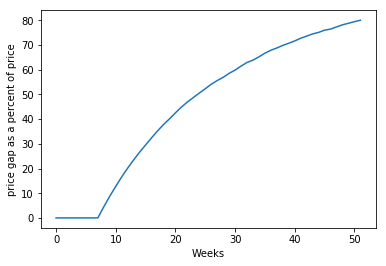

In [19]:
plt.plot(100*(np.array(p_t[:-1])-np.array(floorprice_t))/np.array(p_t[:-1]))
plt.xlabel('Weeks')
plt.ylabel('price gap as a percent of price')

Text(0,0.5,'percent of price at that is supported by unvested tokens')

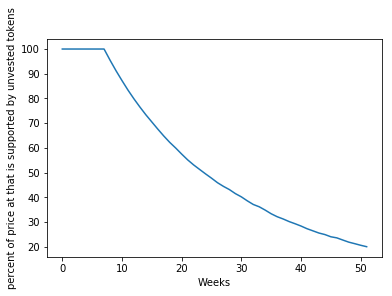

In [20]:
plt.plot(100*(1-(np.array(p_t[:-1])-np.array(floorprice_t))/np.array(p_t[:-1])))
plt.xlabel('Weeks')
plt.ylabel('percent of price at that is supported by unvested tokens')

Text(0,0.5,'percent of tokens that are unvested tokens')

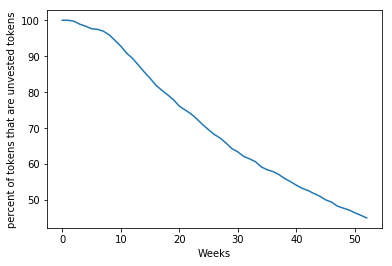

In [21]:
plt.plot(100*np.array(H_t)/np.array(S_t))
plt.xlabel('Weeks')
plt.ylabel('percent of tokens that are unvested tokens')

Text(0,0.5,'percent of price at that is supported by unvested tokens')

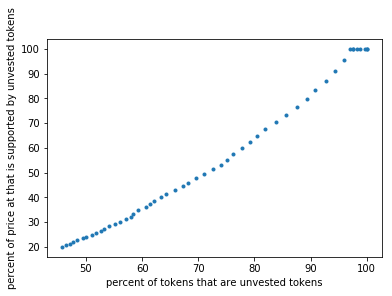

In [22]:
#this is for my analysis purposes. careful about using it for a plot
#in order for it to be intuitive the x-axis should run in reverse
#because as time progresses the percent of tokens that are unvested goes DOWN
#by flipped the x-axis to run from 100 to 0, it would be less confusing to look at.

plt.plot(100*np.array(H_t[:-1])/np.array(S_t[:-1]), 100*(1-(np.array(p_t[:-1])-np.array(floorprice_t))/np.array(p_t[:-1])),'.')
plt.xlabel('percent of tokens that are unvested tokens')
plt.ylabel('percent of price at that is supported by unvested tokens')

Text(0,0.5,'unvested')

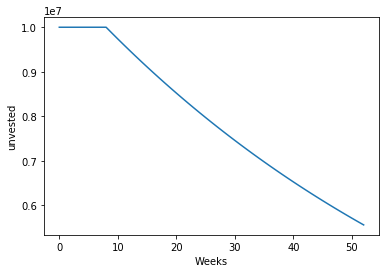

In [23]:
plt.plot(H_t)
plt.xlabel('Weeks')
plt.ylabel('unvested')

Text(0,0.5,'delta R')

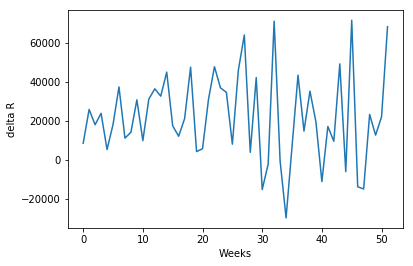

In [24]:
plt.plot(dR_t)
plt.xlabel('Weeks')
plt.ylabel('delta R')

Text(0,0.5,'R')

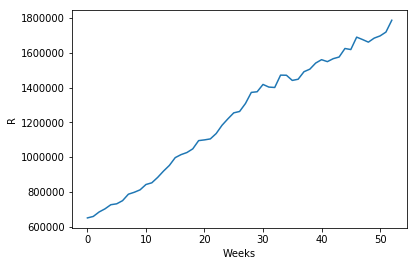

In [25]:
plt.plot(R_t)
plt.xlabel('Weeks')
plt.ylabel('R')

In [26]:
price = np.array(p_t)

In [27]:
delta_price = np.diff(price)

Text(0,0.5,'change price')

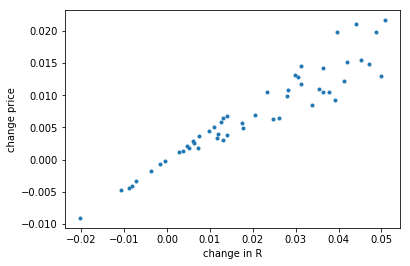

In [28]:
plt.plot(change_rate, delta_price, '.')
plt.xlabel('change in R')
plt.ylabel('change price')

Text(0,0.5,'price')

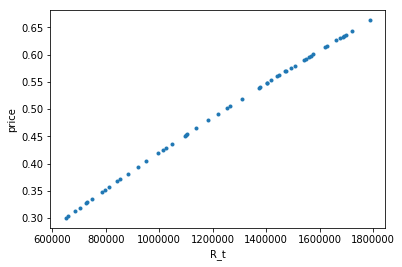

In [29]:
plt.plot(R_t, price, '.')
plt.xlabel('R_t')
plt.ylabel('price')